<a href="https://colab.research.google.com/github/kmchiti/EvolvGNN/blob/main/Science4Cast_tutarial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:

import pickle
import numpy as np
import matplotlib.pyplot as plt

In [12]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Play with Data

In [32]:
root_path = '/content/gdrive/MyDrive/Colab Notebooks/Science4Cast/'
NUM_OF_VERTICES=64719 # number of vertices of the semantic net

data_source = root_path+'TrainSet2014_3.pkl'
full_dynamic_graph_sparse,unconnected_vertex_pairs,year_start,years_delta = pickle.load( open( data_source, "rb" ) )

print(data_source+' has '+str(len(full_dynamic_graph_sparse))+' edges between a total of '+str(NUM_OF_VERTICES)+ ' vertices.\n\n')
print('The goal is to predict which of '+str(len(unconnected_vertex_pairs))+' unconnectedvertex-pairs\nin unconnected_vertex_pairs will be connected until '+str(year_start+years_delta)+'.')



/content/gdrive/MyDrive/Colab Notebooks/Science4Cast/TrainSet2014_3.pkl has 2278611 edges between a total of 64719 vertices.


The goal is to predict which of 1000000 unconnectedvertex-pairs
in unconnected_vertex_pairs will be connected until 2017.


In [33]:
import random

random.seed(42)
print('Type of full_dynamic_graph_sparse: ', type(full_dynamic_graph_sparse))
print('\nExample edges:')
for idx in random.sample(range(len(full_dynamic_graph_sparse)), 5):
    print('Edge in semantic Net (edge #'+str(idx)+'): ', full_dynamic_graph_sparse[idx])
    

Type of full_dynamic_graph_sparse:  <class 'numpy.ndarray'>

Example edges:
Edge in semantic Net (edge #466956):  [35266 36996  7758]
Edge in semantic Net (edge #104902):  [32250 43887  6171]
Edge in semantic Net (edge #1153556):  [32538 47489  8465]
Edge in semantic Net (edge #1027150):  [13238 35059  8387]
Edge in semantic Net (edge #936213):  [ 1298 33622  8311]


In [34]:
creation_time = np.unique(full_dynamic_graph_sparse[:,2])
def node_until_time(t = 5):
  time_slap = full_dynamic_graph_sparse[full_dynamic_graph_sparse[:,2]==creation_time[t]]
  if(t>1):
    res = np.concatenate((time_slap, node_until_time(t-1)))
  else:
    res = time_slap
  return res


Text(0.5, 1.0, 'Until time 501')

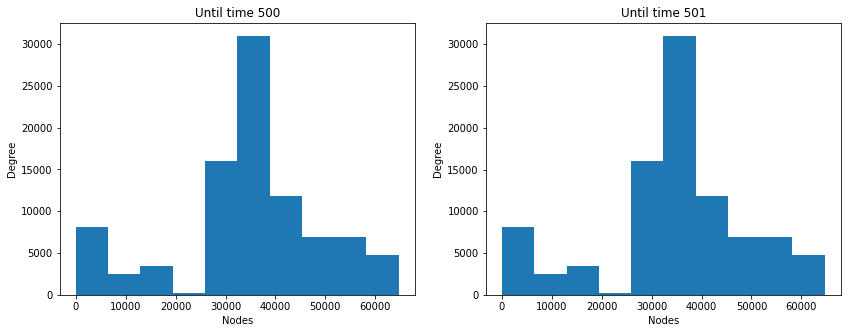

In [35]:
h = plt.figure(figsize=(14,5))
plt.subplot(121)
x = node_until_time(500)
plt.hist(np.concatenate((x[:,0], x[:,1])))
plt.xlabel("Nodes")
plt.ylabel("Degree")
plt.title("Until time 500")
plt.subplot(122)
x = node_until_time(501)
plt.hist(np.concatenate((x[:,0], x[:,1])))
plt.xlabel("Nodes")
plt.ylabel("Degree")
plt.title("Until time 501")

Text(0, 0.5, 'Number of connected nodes')

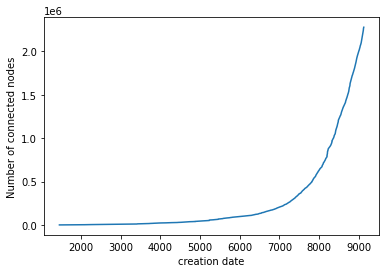

In [36]:
DegSum = []
for i in np.unique(full_dynamic_graph_sparse[:,2]):
  DegSum.append([i, len(full_dynamic_graph_sparse[full_dynamic_graph_sparse[:,2]==i])])
DegSum = np.array(DegSum)
plt.plot(DegSum[:,0], np.cumsum(DegSum[:,1]))
plt.xlabel("creation date")
plt.ylabel("Number of connected nodes")

In [37]:
for idx in random.sample(range(len(unconnected_vertex_pairs)), 5):
    print('Unconnected vertex pairs: ', unconnected_vertex_pairs[idx])
    

Unconnected vertex pairs:  [22768 11701]
Unconnected vertex pairs:  [13374  2149]
Unconnected vertex pairs:  [18646  3268]
Unconnected vertex pairs:  [12087 13432]
Unconnected vertex pairs:  [14672  1739]


In [38]:
from scipy import sparse
import networkx as nx

rnd_vertices=random.sample(range(100),50) # we use 50 random concepts

full_idx0=[]
full_idx1=[]
for ii in range(len(rnd_vertices)): # here we will find all indices of edges where the concept is either the first or the second vertex
    full_idx0=np.concatenate((full_idx0, np.where(full_dynamic_graph_sparse[:,0] == rnd_vertices[ii])[0]))
    full_idx1=np.concatenate((full_idx1, np.where(full_dynamic_graph_sparse[:,1] == rnd_vertices[ii])[0]))

all_idx=list(set(full_idx0) & set(full_idx1))

subgraph_of_semnet=full_dynamic_graph_sparse[np.array(all_idx).astype(int)] # get the corresponding edge

# These vertices have degree(v)>0, i.e. have at least one edge in the subgraph:
rnd_vertices=list(set(list(subgraph_of_semnet[:,0])+list(subgraph_of_semnet[:,1])))
print('Number of edges in the subgraph: ', len(subgraph_of_semnet))
print('Number of non-zero degree vertices in the subgraph: ', len(rnd_vertices))

print('For easier plotting, change names of vertices, from 0 to ', len(rnd_vertices))

print('5 edges of previous list:')
print(subgraph_of_semnet[0:5])
print('\n\n')

for ii in range(len(rnd_vertices)):
    subgraph_of_semnet[:,0]=[ii if x==rnd_vertices[ii] else x for x in subgraph_of_semnet[:,0]]
    subgraph_of_semnet[:,1]=[ii if x==rnd_vertices[ii] else x for x in subgraph_of_semnet[:,1]]

print('5 edges of new list:')
print(subgraph_of_semnet[0:5])

Number of edges in the subgraph:  288
Number of non-zero degree vertices in the subgraph:  43
For easier plotting, change names of vertices, from 0 to  43
5 edges of previous list:
[[  54   54 9067]
 [  54   54 8050]
 [  11   23 7732]
 [  11   75 8683]
 [   4   24 9114]]



5 edges of new list:
[[  24   24 9067]
 [  24   24 8050]
 [   4   10 7732]
 [   4   30 8683]
 [   2   11 9114]]


In [39]:
from datetime import date
day_origin = date(1990,1,1)
years=[2012,2013,2014]

all_nx_nets=[]

for yy in years:
    print('Create Graph for ', yy)
    day_curr=date(yy,12,31)
    all_edges_curr=subgraph_of_semnet[subgraph_of_semnet[:,2]<(day_curr-day_origin).days]
    adj_mat_sparse_curr = sparse.csr_matrix((np.ones(len(all_edges_curr)), (all_edges_curr[:,0], all_edges_curr[:,1])), shape=(len(rnd_vertices),len(rnd_vertices)))
    print('Number of edges: ',adj_mat_sparse_curr.getnnz())
    G_curr=nx.from_scipy_sparse_matrix(adj_mat_sparse_curr, parallel_edges=False, create_using=None, edge_attribute='weight')
    
    all_nx_nets.append(G_curr)

Create Graph for  2012
Number of edges:  62
Create Graph for  2013
Number of edges:  92
Create Graph for  2014
Number of edges:  141


Network of the year  2012


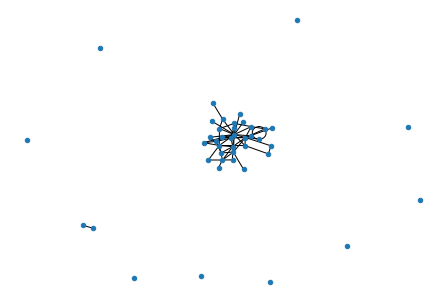

Network of the year  2013


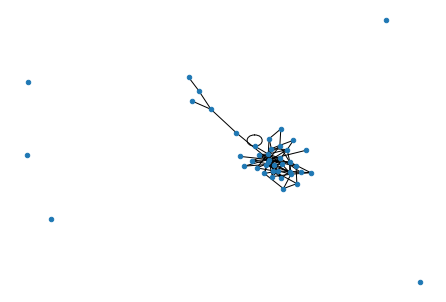

Network of the year  2014


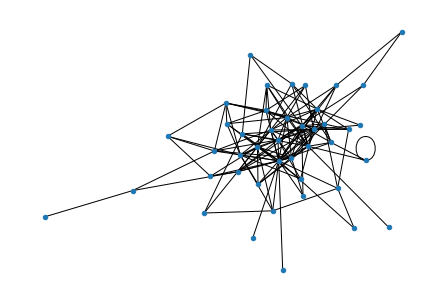

In [40]:
import matplotlib.pyplot as plt

for idx in range(len(all_nx_nets)):
    print('Network of the year ',years[idx])
    curr_net=all_nx_nets[idx]
    nx.draw(curr_net, pos=nx.spring_layout(curr_net), node_size=20)
    plt.show()

# Baseline model

## Creating historic training data


In [41]:
import time

"""
set parameter Wedge to:
  1 -> defult
  2 -> older edges have more weights
  3 -> newer  edges have more weights
"""
Wedge = 1

def create_training_data(full_graph,year_start,years_delta,edges_used=500000,vertex_degree_cutoff=10):
    """
    :param full_graph: Full graph, numpy array dim(n,3) [vertex 1, vertex 2, time stamp]
    :param year_start: year of graph
    :param years_delta: distance for prediction in years (prediction on graph of year_start+years_delta)
    :param edges_used: optional filter to create a random subset of edges for rapid prototyping (default: 500,000)
    :param vertex_degree_cutoff: optional filter, for vertices in training set having a minimal degree of at least vertex_degree_cutoff  (default: 10)
    :return:

    all_edge_list: graph of year_start, numpy array dim(n,2)
    unconnected_vertex_pairs: potential edges for year_start+years_delta
    unconnected_vertex_pairs_solution: numpy array with integers (0=unconnected, 1=connected), solution, length = len(unconnected_vertex_pairs)
    """

    years=[year_start,year_start+years_delta]    
    day_origin = date(1990,1,1)

    all_G=[]
    all_edge_lists=[]
    all_sparse=[]
    for yy in years:
        print('    Create Graph for ', yy)
        day_curr=date(yy,12,31)
        all_edges_curr=full_graph[full_graph[:,2]<(day_curr-day_origin).days]
        adj_mat_sparse_curr = sparse.csr_matrix((np.ones(len(all_edges_curr)), (all_edges_curr[:,0], all_edges_curr[:,1])), shape=(NUM_OF_VERTICES,NUM_OF_VERTICES))
        G_curr=nx.from_scipy_sparse_matrix(adj_mat_sparse_curr, parallel_edges=False, create_using=None, edge_attribute='weight')

        all_G.append(G_curr)
        all_sparse.append(adj_mat_sparse_curr)
        all_edge_lists.append(all_edges_curr)

        print('    Done: Create Graph for ', yy)
        print('    num of edges: ', G_curr.number_of_edges())

    all_degs=np.array(all_sparse[0].sum(0))[0]

    ## Create all edges to be predicted
    all_vertices=np.array(range(NUM_OF_VERTICES))
    vertex_large_degs=all_vertices[all_degs>=vertex_degree_cutoff] # use only vertices with degrees larger than 10.

    unconnected_vertex_pairs=[]
    unconnected_vertex_pairs_solution=[]

    time_start=time.time()
    while len(unconnected_vertex_pairs)<edges_used:        
        v1,v2=random.sample(range(len(vertex_large_degs)), 2)

        if v1!=v2 and not all_G[0].has_edge(v1,v2):
            if len(unconnected_vertex_pairs)%10**6==0:
                time_end=time.time()
                print('    edge progress (',time_end-time_start,'sec): ',len(unconnected_vertex_pairs)/10**6,'M/',edges_used/10**6,'M')
                time_start=time.time()
            unconnected_vertex_pairs.append((v1,v2))
            unconnected_vertex_pairs_solution.append(all_G[1].has_edge(v1,v2))

        
    print('Number of unconnected vertex pairs for prediction: ', len(unconnected_vertex_pairs_solution))
    print('Number of vertex pairs that will be connected: ' , sum(unconnected_vertex_pairs_solution))
    print('Ratio of vertex pairs that will be connected: ' , sum(unconnected_vertex_pairs_solution)/len(unconnected_vertex_pairs_solution))
    
    unconnected_vertex_pairs=np.array(unconnected_vertex_pairs)
    unconnected_vertex_pairs_solution=np.array(list(map(int, unconnected_vertex_pairs_solution)))
    all_edge_list=np.array(all_edge_lists[0])
    
    return all_edge_list, unconnected_vertex_pairs, unconnected_vertex_pairs_solution

edges_used=1*10**6 # Best would be to use all vertices, to create more training data. But that takes long and requires huge amount of memory. So here we use a random subset.
vertex_degree_cutoff=10
train_dynamic_graph_sparse,train_edges_for_checking,train_edges_solution = create_training_data(full_dynamic_graph_sparse, year_start-years_delta, years_delta, edges_used=edges_used, vertex_degree_cutoff=vertex_degree_cutoff)

day_origin = date(1990,1,1)
years=[year_start-3,year_start-4,year_start-5]

train_sparse=[]
for yy in years:
    print('    Create Graph for ', yy)
    day_curr=date(yy,12,31)
    train_edges_curr=train_dynamic_graph_sparse[train_dynamic_graph_sparse[:,2]<(day_curr-day_origin).days]

    if(Wedge==1):
      adj_mat_sparse_curr = sparse.csr_matrix((np.ones(len(train_edges_curr)), (train_edges_curr[:,0], train_edges_curr[:,1])), shape=(NUM_OF_VERTICES,NUM_OF_VERTICES))
    
    elif(Wedge==2):
      time_step = train_edges_curr[:,2].max() + 1
      x = time_step*np.ones(len(train_edges_curr)) - train_edges_curr[:,2]
      adj_mat_sparse_curr = sparse.csr_matrix((x, (train_edges_curr[:,0], train_edges_curr[:,1])), shape=(NUM_OF_VERTICES,NUM_OF_VERTICES))
    
    elif(Wedge==3):
      time_step = train_edges_curr[:,2].min() 
      x =  train_edges_curr[:,2] - time_step*np.ones(len(train_edges_curr))
      adj_mat_sparse_curr = sparse.csr_matrix((x, (train_edges_curr[:,0], train_edges_curr[:,1])), shape=(NUM_OF_VERTICES,NUM_OF_VERTICES))

      #x = (x - x.mean())/ x.std()
      #x = x/ np.linalg.norm(x)

    train_sparse.append(adj_mat_sparse_curr)
print('done')

    Create Graph for  2011
    Done: Create Graph for  2011
    num of edges:  567750
    Create Graph for  2014
    Done: Create Graph for  2014
    num of edges:  1843253
    edge progress ( 8.177757263183594e-05 sec):  0.0 M/ 1.0 M
Number of unconnected vertex pairs for prediction:  1000000
Number of vertex pairs that will be connected:  329
Ratio of vertex pairs that will be connected:  0.000329
    Create Graph for  2011
    Create Graph for  2010
    Create Graph for  2009
done


In [42]:
print("all_edge_list:", train_dynamic_graph_sparse.shape)
print("unconnected_vertex_pairs:", train_edges_for_checking.shape, "Sol:", train_edges_solution.shape)
print("\n unconnected_vertex_pairs means some possible vertex pairs on validation data(2014)\n that are not connected in train data(2011). in fact, its output of NN")


all_edge_list: (651997, 3)
unconnected_vertex_pairs: (1000000, 2) Sol: (1000000,)

 unconnected_vertex_pairs means some possible vertex pairs on validation data(2014)
 that are not connected in train data(2011). in fact, its output of NN


## Training a baseline model

In [43]:

print('    Shuffle training data...')
train_valid_test_size=[0.9, 0.1, 0.0]
x = [i for i in range(len(train_edges_for_checking))]  # random shuffle input

random.shuffle(x)
train_edges_for_checking = train_edges_for_checking[x]
train_edges_solution = train_edges_solution[x]

print('    Split dataset...')
idx_traintest=int(len(train_edges_for_checking)*train_valid_test_size[0])

data_edges_train=train_edges_for_checking[0:idx_traintest]
solution_train=train_edges_solution[0:idx_traintest]  

data_edges_test=train_edges_for_checking[idx_traintest:]
solution_test=train_edges_solution[idx_traintest:]

print('Training, connected  : ',sum(solution_train==1))
print('Training, unconnected: ',sum(solution_train==0))

    Shuffle training data...
    Split dataset...
Training, connected  :  272
Training, unconnected:  899728


In [44]:
print("Trainig data", data_edges_train.shape, "Training solution:", solution_train.shape)
print("Test data", data_edges_test.shape, "Test solution:", solution_test.shape)

Trainig data (900000, 2) Training solution: (900000,)
Test data (100000, 2) Test solution: (100000,)


## Creating features

Features:

* degree of v1 and v2 in the current year (in validation 2011) and previous two years. (These are six properties)
* number of shared neighbors in total of v1 and v2 in the current year (in validation 2011) and previous two years. (These are six properties)
* number of shared neighbors between v1 and v2 in the current year (in validation 2011) and previous two years. (These are 3 properties)

We only use about 1% of the unconnected examples for training, as computing features is expensive, and the two classes (connected vs unconnected) are very unevenly distributed.

In [45]:
# import scipy

# def normalize_degree(adj):
#   deg = np.power(np.squeeze(np.array((adj.sum(axis=1)))), -0.5)
#   deg[np.isinf(deg)] = 0
#   deg_inv_sq = scipy.sparse.diags(deg)
#   adj = deg_inv_sq @ adj@  deg_inv_sq
#   return adj
# D = normalize_degree(train_sparse[0])

In [46]:
import scipy

def normalize_degree(adj):
  deg = np.power(np.squeeze(np.array((adj.sum(axis=1)))), -0.5)
  deg[np.isinf(deg)] = 0
  deg_inv_sq = scipy.sparse.diags(deg)
  adj = deg_inv_sq @ adj@  deg_inv_sq
  return adj

def compute_all_properties(all_sparse,AA02,AA12,AA22,all_degs0,all_degs1,all_degs2,all_degs02,all_degs12,all_degs22,v1,v2):
    """
    Computes hand-crafted properties for one vertex in vlist
    """
    all_properties=[]

    all_properties.append(all_degs0[v1]) # 0
    all_properties.append(all_degs0[v2]) # 1
    all_properties.append(all_degs1[v1]) # 2
    all_properties.append(all_degs1[v2]) # 3
    all_properties.append(all_degs2[v1]) # 4
    all_properties.append(all_degs2[v2]) # 5
    all_properties.append(all_degs02[v1]) # 6
    all_properties.append(all_degs02[v2]) # 7
    all_properties.append(all_degs12[v1]) # 8
    all_properties.append(all_degs12[v2]) # 9
    all_properties.append(all_degs22[v1]) # 10
    all_properties.append(all_degs22[v2]) # 11

    all_properties.append(AA02[v1,v2]) # 12
    all_properties.append(AA12[v1,v2]) # 13
    all_properties.append(AA22[v1,v2]) # 14    

    return all_properties



def compute_all_properties_of_list(all_sparse,vlist):
    """
    Computes hand-crafted properties for all vertices in vlist
    """
    time_start=time.time()
    #normalaize Adjnc matrix for each year(2009,2010,2011)
    #all_sparse[0] = normalize_degree(all_sparse[0])
    #all_sparse[1] = normalize_degree(all_sparse[1])
    #all_sparse[2] = normalize_degree(all_sparse[2])


    AA02=all_sparse[0]@all_sparse[0]
    #lenghth = AA02.shape[0]
    #jafar = scipy.sparse.ones((lenghth,lenghth)) - scipy.sparse.eye(lenghth)
    #AA02 = AA02 * jafar
    AA02 = AA02.tocoo()
    AA02.data[AA02.row == AA02.col] = 0
    AA02 = AA02.tocsr()
    AA02=AA02/AA02.max()

    AA12=all_sparse[1]@all_sparse[1]
    AA12 = AA12.tocoo()
    AA12.data[AA12.row == AA12.col] = 0
    AA12 = AA12.tocsr()
    AA12=AA12/AA12.max()

    AA22=all_sparse[2]@all_sparse[2]
    AA22 = AA22.tocoo()
    AA22.data[AA22.row == AA22.col] = 0
    AA22 = AA22.tocsr()    
    AA22=AA22/AA22.max()
    
    all_degs0=np.array(all_sparse[0].sum(0))[0]
    if np.max(all_degs0)>0:
        all_degs0=all_degs0/np.max(all_degs0)
        
    all_degs1=np.array(all_sparse[1].sum(0))[0]
    if np.max(all_degs1)>0:
        all_degs1=all_degs1/np.max(all_degs1)
    
    all_degs2=np.array(all_sparse[2].sum(0))[0]
    if np.max(all_degs2)>0:
        all_degs2=all_degs2/np.max(all_degs2)

    ##########################################

    all_degs02=np.array(AA02.sum(0))[0]
    if np.max(all_degs2)>0:
        all_degs02=all_degs02/np.max(all_degs02)
        
    all_degs12=np.array(AA12.sum(0))[0]
    if np.max(all_degs12)>0:
        all_degs12=all_degs12/np.max(all_degs12)
        
    all_degs22=np.array(AA22.sum(0))[0]
    if np.max(all_degs22)>0:
        all_degs22=all_degs22/np.max(all_degs22)
    
    all_properties=[]
    print('    Computed all matrix squares, ready to ruuuumbleeee...')
    for ii in range(len(vlist)):
        vals=compute_all_properties(all_sparse,
                                    AA02,
                                    AA12,
                                    AA22,
                                    all_degs0,
                                    all_degs1,
                                    all_degs2,
                                    all_degs02,
                                    all_degs12,
                                    all_degs22,
                                    vlist[ii][0],
                                    vlist[ii][1])

        all_properties.append(vals)
        if ii%10**5==0:
            print('compute features: (',time.time()-time_start,'sec) ',ii/10**6,'M/',len(vlist)/10**6,'M')
            time_start=time.time()

    return all_properties

# Rather than using all connected and unconnected vertex pairs for training
# (i.e. needing to compute their properties), we reject about 99% of all unconnected
# examples, to have more examples of connected cases in the training. This significantly
# speeds up the computation, at the price of precision.
data_edges_train_smaller=[]
solution_train_smaller=[]
for ii in range(len(data_edges_train)):
    if (solution_train[ii]==0 and random.random()<0.01) or solution_train[ii]==1:
        data_edges_train_smaller.append(data_edges_train[ii])
        solution_train_smaller.append(solution_train[ii])

data_train=compute_all_properties_of_list(train_sparse,data_edges_train_smaller)

data_train0=[]
data_train1=[]
for ii in range(len(data_edges_train_smaller)):
    if solution_train_smaller[ii]==1:
        data_train1.append(data_train[ii])
    else:
        data_train0.append(data_train[ii])

data_test=compute_all_properties_of_list(train_sparse,data_edges_test)
data_test0=[]
data_test1=[]
for ii in range(len(data_edges_test)):
    if solution_test[ii]==1:
        data_test1.append(data_test[ii])
    else:
        data_test0.append(data_test[ii])
print('done')

    Computed all matrix squares, ready to ruuuumbleeee...
compute features: ( 4.900857210159302 sec)  0.0 M/ 0.009245 M
    Computed all matrix squares, ready to ruuuumbleeee...
compute features: ( 4.873225688934326 sec)  0.0 M/ 0.1 M
done


0 - train:  1.3863086 ; test:  1.3863084
50 - train:  1.3862401 ; test:  1.386236
100 - train:  1.3859465 ; test:  1.3859203
150 - train:  1.3841311 ; test:  1.3839595
200 - train:  1.3784587 ; test:  1.3777983
250 - train:  1.3667915 ; test:  1.3651667
300 - train:  1.3499016 ; test:  1.346518
350 - train:  1.3284419 ; test:  1.3223921
400 - train:  1.3085594 ; test:  1.2984688
450 - train:  1.2834953 ; test:  1.2697291
500 - train:  1.2645774 ; test:  1.2461796
550 - train:  1.2486477 ; test:  1.2259047
600 - train:  1.236725 ; test:  1.2085805
650 - train:  1.2305796 ; test:  1.2042819
700 - train:  1.2223387 ; test:  1.1934309
750 - train:  1.2166822 ; test:  1.1849811
Early stopping kicked in


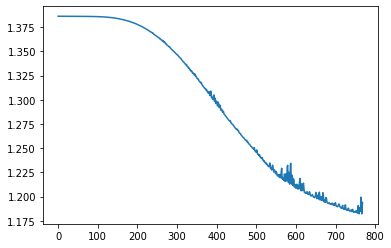

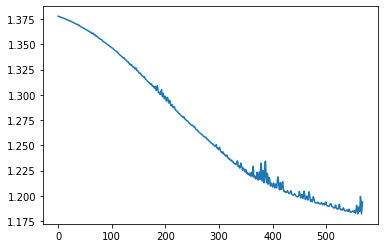

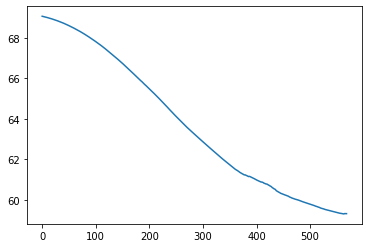

done


In [47]:
import torch
from torch import nn

class ff_network(nn.Module):

    def __init__(self):
        """
        Fully Connected layers
        """
        super(ff_network, self).__init__()

        self.semnet = nn.Sequential( # very small network for tests
            nn.Linear(15, 100), # 15 properties
            nn.ReLU(),
            nn.Linear(100, 100), 
            nn.ReLU(),       
            nn.Linear(100, 10),
            nn.ReLU(),             
            nn.Linear(10, 1)
        )


    def forward(self, x):
        """
        Pass throught network
        """
        res = self.semnet(x)

        return res


def train_model(model_semnet, data_train0, data_train1, data_test0, data_test1, lr_enc, batch_size):
    """
    Training the neural network
    """    
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    size_of_loss_check=2000
    
    optimizer_predictor = torch.optim.Adam(model_semnet.parameters(), lr=lr_enc)
    
    data_train0=torch.tensor(data_train0, dtype=torch.float).to(device)
    data_test0=torch.tensor(data_test0, dtype=torch.float).to(device)
    
    data_train1=torch.tensor(data_train1, dtype=torch.float).to(device)
    data_test1=torch.tensor(data_test1, dtype=torch.float).to(device)

    test_loss_total=[]
    moving_avg=[]
    #criterion = torch.nn.MSELoss()
    criterion = torch.nn.BCEWithLogitsLoss()
    
    # There are much more vertex pairs that wont be connected (0) rather than ones
    # that will be connected (1). However, we observed that training with an equally weighted
    # training set (same number of examples for (0) and (1)) results in more stable training.
    # (Imaging we have 1.000.000 nonconnected and 10.000 connected)
    #
    # For that reason, we dont have true 'episodes' (where each example from the training set
    # has been used in the training). Rather, in each of our iteration, we sample batch_size
    # random training examples from data_train0 and from data_train1.
    
    for iteration in range(10000): # should be much larger, with good early stopping criteria
        model_semnet.train()
        data_sets=[data_train0,data_train1]
        total_loss=0
        for idx_dataset in range(len(data_sets)):
            idx = torch.randint(0, len(data_sets[idx_dataset]), (batch_size,))
            data_train_samples = data_sets[idx_dataset][idx]
            calc_properties = model_semnet(data_train_samples)
            curr_pred=torch.tensor([idx_dataset] * batch_size, dtype=torch.float).to(device)
            real_loss = criterion(calc_properties, curr_pred.unsqueeze(dim=1))
            total_loss += torch.clamp(real_loss, min = 0., max = 50000.).double()

        optimizer_predictor.zero_grad()
        total_loss.backward()
        optimizer_predictor.step()

        # Evaluating the current quality.
        with torch.no_grad():
            model_semnet.eval()
            # calculate train set
            eval_datasets=[data_train0,data_train1,data_test0,data_test1]
            all_real_loss=[]
            for idx_dataset in range(len(eval_datasets)):
                eval_datasets[idx_dataset]
                calc_properties = model_semnet(eval_datasets[idx_dataset][0:size_of_loss_check])        
                curr_pred=torch.tensor([idx_dataset%2] * len(eval_datasets[idx_dataset][0:size_of_loss_check]), dtype=torch.float).to(device)
                real_loss = criterion(calc_properties, curr_pred.unsqueeze(dim=1))
                all_real_loss.append(real_loss.detach().cpu().numpy())
             
            test_loss_total.append(np.mean(all_real_loss[2])+np.mean(all_real_loss[3]))

            if iteration%50==0:
                print(str(iteration)+' - train: ',np.mean(all_real_loss[0])+np.mean(all_real_loss[1]),'; test: ',np.mean(all_real_loss[2])+np.mean(all_real_loss[3]))


            if len(test_loss_total)>200: # early stopping
                test_loss_moving_avg=sum(test_loss_total[-50:])
                moving_avg.append(test_loss_moving_avg)
                if len(moving_avg)>10:
                    if moving_avg[-1]>moving_avg[-2] and moving_avg[-1]>moving_avg[-10]:
                        print('Early stopping kicked in')
                        break

    plt.plot(test_loss_total)
    plt.show()
    
    plt.plot(test_loss_total[200:])
    plt.show()    
    
    plt.plot(moving_avg)
    plt.show()

    return True

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_semnet = ff_network().to(device)

batch_size=100 # Large batch_size seems to be important
lr_enc=5*10**-4

model_semnet.train()
train_model(model_semnet, data_train0, data_train1, data_test0, data_test1, lr_enc, batch_size)  
print('done')

## Computing the metric

Defult


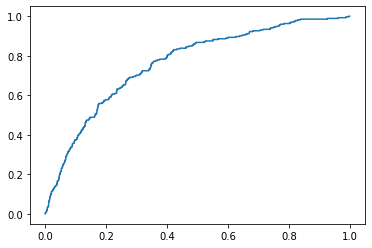

    AUC_train:  0.7623245553654108


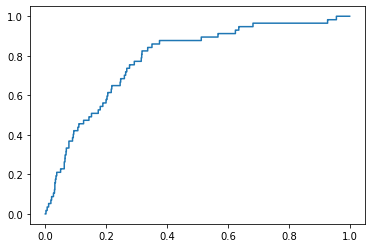

    AUC_test:  0.7867644206325433


In [48]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

if(Wedge==1):
  print("Defult")
elif(Wedge==2):
  print("Older edge are more important")
elif(Wedge==3):
  print("Newer edge are more important")

def flatten(t):
    return [item for sublist in t for item in sublist]

def calculate_ROC(data_vertex_pairs,data_solution):
    data_solution=np.array(data_solution)
    data_vertex_pairs_sorted=data_solution[data_vertex_pairs]
    
    xpos=[0]
    ypos=[0]
    ROC_vals=[]
    for ii in range(len(data_vertex_pairs_sorted)):
        if data_vertex_pairs_sorted[ii]==1:
            xpos.append(xpos[-1])
            ypos.append(ypos[-1]+1)
        if data_vertex_pairs_sorted[ii]==0:
            xpos.append(xpos[-1]+1)
            ypos.append(ypos[-1])      
            ROC_vals.append(ypos[-1])
    
        # # # # # # # # # # # # # # # 
        # 
        # We normalize the ROC curve such that it starts at (0,0) and ends at (1,1).
        # Then our final metric of interest is the Area under that curve.
        # AUC is between [0,1].
        # AUC = 0.5 is acchieved by random predictions
        # AUC = 1.0 stands for perfect prediction.
    
    ROC_vals=np.array(ROC_vals)/max(ypos)
    ypos=np.array(ypos)/max(ypos)
    xpos=np.array(xpos)/max(xpos)
    
    plt.plot(xpos, ypos)
    plt.show()
    
    AUC=sum(ROC_vals)/len(ROC_vals)
    return AUC

data_train=torch.tensor(data_train, dtype=torch.float).to(device)
all_predictions_train=flatten(model_semnet(data_train).detach().cpu().numpy())
sorted_predictions_train=np.flip(np.argsort(all_predictions_train,axis=0))    
AUC_train=calculate_ROC(sorted_predictions_train, solution_train_smaller)
print('    AUC_train: ', AUC_train)

data_test=torch.tensor(data_test, dtype=torch.float).to(device)
all_predictions_test=flatten(model_semnet(data_test).detach().cpu().numpy())
sorted_predictions_test=np.flip(np.argsort(all_predictions_test,axis=0))    
AUC_test=calculate_ROC(sorted_predictions_test, solution_test)
print('    AUC_test: ', AUC_test)

## Evaluating Testset for Competition

In [ ]:
# Create properties for evaluation
print('2) Makes predictions for '+str(year_start)+' -> '+str(year_start+3)+' data.')
years=[year_start,year_start-1,year_start-2]

print('2.1) Computes the 15 properties for the '+str(year_start)+' data.')
eval_sparse=[]
for yy in years:
    print('    Create Graph for ', yy)
    day_curr=date(yy,12,31)
    eval_edges_curr=full_dynamic_graph_sparse[full_dynamic_graph_sparse[:,2]<(day_curr-day_origin).days]
    adj_mat_sparse_curr = sparse.csr_matrix(
                                            (np.ones(len(eval_edges_curr)), (eval_edges_curr[:,0], eval_edges_curr[:,1])),
                                            shape=(NUM_OF_VERTICES,NUM_OF_VERTICES)
                                           )

    eval_sparse.append(adj_mat_sparse_curr)

print('    compute all properties for evaluation')
eval_examples=compute_all_properties_of_list(eval_sparse,unconnected_vertex_pairs)
eval_examples=np.array(eval_examples)

print('2.2) Uses the trained network to predict whether edges are created by '+str(year_start+3)+'.')
eval_examples=torch.tensor(eval_examples, dtype=torch.float).to(device)
all_predictions_eval=flatten(model_semnet(eval_examples).detach().cpu().numpy())

print('3) Creates a sorted index list, from highest predicted vertex pair to least predicted one (sorted_predictions)')
sorted_predictions_eval=np.flip(np.argsort(all_predictions_eval,axis=0))

2) Makes predictions for 2014 -> 2017 data.
2.1) Computes the 15 properties for the 2014 data.
    Create Graph for  2014
    Create Graph for  2013
    Create Graph for  2012
    compute all properties for evaluation
    Computed all matrix squares, ready to ruuuumbleeee...
compute features: ( 27.74684166908264 sec)  0.0 M/ 1.0 M
compute features: ( 10.098329305648804 sec)  0.1 M/ 1.0 M
compute features: ( 10.260680913925171 sec)  0.2 M/ 1.0 M
compute features: ( 10.083306312561035 sec)  0.3 M/ 1.0 M
compute features: ( 10.234050273895264 sec)  0.4 M/ 1.0 M
compute features: ( 9.751564025878906 sec)  0.5 M/ 1.0 M
compute features: ( 10.06593108177185 sec)  0.6 M/ 1.0 M
compute features: ( 9.82743525505066 sec)  0.7 M/ 1.0 M
compute features: ( 10.369754552841187 sec)  0.8 M/ 1.0 M
compute features: ( 10.046702146530151 sec)  0.9 M/ 1.0 M
2.2) Uses the trained network to predict whether edges are created by 2017.
3) Creates a sorted index list, from highest predicted vertex pair to lea

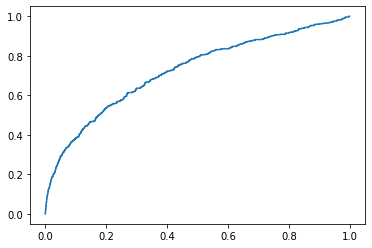

Area Under Curve for Evaluation:  0.7236236854557452 





In [ ]:
import json

if year_start==2017:
    # Save the results for submission.
    submit_file="model_all_idx"+str(year_start)+"_"+str(years_delta)+".json"
    all_idx_list_float=list(map(float, all_idx))
    with open(submit_file, "w", encoding="utf8") as json_file:
        json.dump(all_idx_list_float, json_file)
    
    print("Solution stored as "+submit_file+".\nLooking forward to your submission.")        

else:
    with open(root_path+'TrainSet2014_3_solution.pkl', "rb" ) as pkl_file:
        unconnected_vertex_pairs_solution = pickle.load(pkl_file)
    
    AUC=calculate_ROC(sorted_predictions_eval, np.array(unconnected_vertex_pairs_solution))
    print('Area Under Curve for Evaluation: ', AUC,'\n\n\n')
